# Multiple models comparison

In [115]:
import boto3
from time import sleep
import pandas as pd
import seaborn as sns
import pprint
pp = pprint.PrettyPrinter(indent=2)

In [55]:
session = boto3.Session(region_name='us-west-2')  #  Ireland: eu-west-1
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [56]:
project = 'util_power_forecastdemo' # This should be the same as your previous notebook

In [57]:
datasetGroupArn = 'arn:aws:forecast:eu-west-1:553700203877:dataset-group/util_power_forecastdemo_dsg'  # Fill in the quotes from the output of the previous notebook.

In [58]:
algos = ['Prophet', 'ETS', 'Deep_AR_Plus']

predictors = {a:{} for a in algos}

for p in predictors:
    predictors[p]['predictor_name'] = project + '_' + p + '_algo'
    predictors[p]['algorithm_arn'] = 'arn:aws:forecast:::algorithm/' + p

pp.pprint(predictors)

{ 'Deep_AR_Plus': { 'algorithm_arn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                    'predictor_name': 'util_power_forecastdemo_Deep_AR_Plus_algo'},
  'ETS': { 'algorithm_arn': 'arn:aws:forecast:::algorithm/ETS',
           'predictor_name': 'util_power_forecastdemo_ETS_algo'},
  'Prophet': { 'algorithm_arn': 'arn:aws:forecast:::algorithm/Prophet',
               'predictor_name': 'util_power_forecastdemo_Prophet_algo'}}


In [59]:
forecastHorizon = 24

### Create multiple predictors

In [60]:
def create_predictor_response(pred_name, algo_arn, forecast_horizon):
    response=forecast.create_predictor(PredictorName=pred_name, 
                                       AlgorithmArn=algo_arn,
                                       ForecastHorizon=forecast_horizon,
                                       PerformAutoML= False,
                                       PerformHPO=False,
                                       EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                              "BackTestWindowOffset": 24}, 
                                       InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                       FeaturizationConfig= {"ForecastFrequency": "H", 
                                                             "Featurizations": 
                                                             [
                                                                 {"AttributeName": "target_value", 
                                                                  "FeaturizationPipeline": 
                                                                  [
                                                                      {"FeaturizationMethodName": "filling", 
                                                                       "FeaturizationMethodParameters": 
                                                                       {"frontfill": "none", 
                                                                        "middlefill": "zero", 
                                                                        "backfill": "zero"}
                                                                      }
                                                                  ]
                                                                 }
                                                             ]
                                                            }
                                      )
    return response

In [ ]:
for p in predictors.keys():
    predictor_response = create_predictor_response(predictors[p]['predictor_name'], predictors[p]['algorithm_arn'], forecastHorizon)
    
    predictorArn=predictor_response['PredictorArn']
    
    # wait for the predictor to be actually created
    print('------------------ Creating ' + p)
    while True:
        predictorStatus = forecast.describe_predictor(PredictorArn=predictorArn)['Status']
        print(predictorStatus)
        if predictorStatus != 'ACTIVE' and predictorStatus != 'CREATE_FAILED':
            sleep(30)
        else:
            predictors[p]['predictor_arn'] = predictorArn  # save it, just for reference
            break
            
    # compute accuracy metrics, then proceed with the next algorithm        
    predictors[p]['accuracy'] = forecast.get_accuracy_metrics(PredictorArn=predictorArn)

------------------ Creating Prophet
CREATE_PENDING
CREATE_IN_PROGRESS


**TODO:** (Bar?)plot RMSE, 0.9-, 0.5- and 0.1-quantile LossValues for each algorithm

In [62]:
pp.pprint(predictors)

{ 'Deep_AR_Plus': { 'accuracy': { 'PredictorEvaluationResults': [ { 'TestWindows': [ { 'EvaluationType': 'SUMMARY',
                                                                                       'Metrics': { 'RMSE': 6.175258468529046,
                                                                                                    'WeightedQuantileLosses': [ { 'LossValue': 0.04174349584582985,
                                                                                                                                  'Quantile': 0.9},
                                                                                                                                { 'LossValue': 0.08105242114194346,
                                                                                                                                  'Quantile': 0.5},
                                                                                                                                { 'Lo

In [124]:
scores = pd.DataFrame(columns=['predictor', 'RMSE'])
for p in predictors:
    score = predictors[p]['accuracy']['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['RMSE']
    scores = scores.append(pd.DataFrame({'predictor':[p], 'RMSE':[score]}), ignore_index=True)

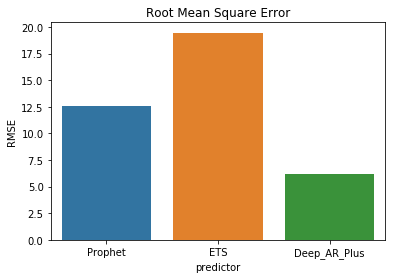

In [130]:
fig = sns.barplot(data=scores, x='predictor', y='RMSE').set_title('Root Mean Square Error')